<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Introduction to Machine Learning
</font>
<br>
<font size=5>
Project -
Phase 2 - Part1

<br>
<font size=5>
Secure RBM
<br>

</font>
<font size=5>
fariborz kohanzad 400103613
<br>
</font>
<font size=4>
Winter 2025
<br>
</font>
<font face="Times New Roman" size=4>
</font>
</div></font>


# regular RBM

In [175]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [165]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x > 0.5).float())  # Binarize the data
        #transforms.Normalize((0.5,), (0.5,))
    ])

# Load the MNIST dataset
def load_mnist(batch_size=64):
        train_dataset = datasets.MNIST(
            root="./data",
            train=True,
            transform=transform,
            download=True
        )

        test_dataset = datasets.MNIST(
            root="./data",
            train=False,
            transform=transform,
            download=True
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False
        )

        return train_loader, test_loader

train_loader, test_loader = load_mnist()

In [166]:
class RBM:
    def __init__(self, input=None, n_visible=784, n_hidden=128, W=None, hbias=None, vbias=None, numpy_rng=None):
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        if numpy_rng is None:
            numpy_rng = np.random.RandomState(1234)

        if W is None:
            a = 1. / n_visible
            W = numpy_rng.uniform(-a, a, size=(n_visible, n_hidden))

        if hbias is None:
            hbias = np.zeros(n_hidden)

        if vbias is None:
            vbias = np.zeros(n_visible)

        self.W = W
        self.hbias = hbias
        self.vbias = vbias
        self.numpy_rng = numpy_rng

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample_h_given_v(self, v):
        h_mean = self.sigmoid(np.dot(v, self.W) + self.hbias)
        h_sample = self.numpy_rng.binomial(size=h_mean.shape, n=1, p=h_mean)
        return h_mean, h_sample

    def sample_v_given_h(self, h):
        v_mean = self.sigmoid(np.dot(h, self.W.T) + self.vbias)
        v_sample = self.numpy_rng.binomial(size=v_mean.shape, n=1, p=v_mean)
        return v_mean, v_sample

    def gibbs_hvh(self, h0_sample):
        v_mean, v_sample = self.sample_v_given_h(h0_sample)
        h_mean, h_sample = self.sample_h_given_v(v_sample)
        return v_mean, v_sample, h_mean, h_sample

    def contrastive_divergence(self, data, k=1, lr=0.1):
        ph_mean, ph_sample = self.sample_h_given_v(data)

        chain_start = ph_sample
        for step in range(k):
            if step == 0:
                nv_mean, nv_sample, nh_mean, nh_sample = self.gibbs_hvh(chain_start)
            else:
                nv_mean, nv_sample, nh_mean, nh_sample = self.gibbs_hvh(nh_sample)

        self.W += lr * (np.dot(data.T, ph_sample) - np.dot(nv_sample.T, nh_mean)) / len(data)
        self.vbias += lr * np.mean(data - nv_sample, axis=0)
        self.hbias += lr * np.mean(ph_sample - nh_mean, axis=0)

    def reconstruct(self, v):
        h = self.sigmoid(np.dot(v, self.W) + self.hbias)
        reconstructed_v = self.sigmoid(np.dot(h, self.W.T) + self.vbias)
        return reconstructed_v

    def save_model(self, file_path):
        with open(file_path, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load_model(file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)

In [167]:
def train_rbm(train_loader, test_loader, n_visible, n_hidden, learning_rate, epochs, k):
      rbm = RBM(n_visible=n_visible, n_hidden=n_hidden)

      for epoch in range(epochs):
            for batch, _ in train_loader:
                batch = batch.view(-1, n_visible).numpy()
                rbm.contrastive_divergence(batch, k=k, lr=learning_rate)

            test_data = next(iter(test_loader))[0].view(-1, n_visible).numpy()
            reconstruction = rbm.reconstruct(test_data)
            loss = np.mean((test_data - reconstruction) ** 2)
            print(f"Epoch {epoch + 1}, k={k}: Reconstruction Loss = {loss:.4f}")

      return rbm

In [168]:
regular_rbm = RBM.load_model("rbm_k1.pkl")

In [181]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Extract features using RBM
def extract_features_rbm(rbm, loader):
    features = []
    labels = []

    with torch.no_grad():
        for batch, lbls in loader:
            batch = batch.view(-1, rbm.n_visible)
            prob_h , _ = rbm.sample_h_given_v(batch)
            features.append(prob_h)
            labels.append(lbls)

    return features, labels

transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
x_train_rbm, y_train_rbm = extract_features_rbm(regular_rbm, train_loader)
x_test_rbm, y_test_rbm = extract_features_rbm(regular_rbm, test_loader)

# Train a logistic regression model on RBM features
clf_rbm = LogisticRegression(max_iter=1000)
clf_rbm.fit(np.array(x_train_rbm).squeeze(1), np.array(y_train_rbm).squeeze(1))

# Evaluate the model
y_pred_rbm = clf_rbm.predict(np.array(x_test_rbm).squeeze(1))
accuracy_rbm = accuracy_score(np.array(y_test_rbm).squeeze(1), y_pred_rbm)
print(f"RBM Feature Classification Accuracy: {accuracy_rbm:.4f}")


RBM Feature Classification Accuracy: 0.9353


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.92      0.93      1032
           3       0.91      0.93      0.92      1010
           4       0.91      0.94      0.92       982
           5       0.93      0.90      0.92       892
           6       0.95      0.96      0.96       958
           7       0.94      0.93      0.94      1028
           8       0.90      0.91      0.91       974
           9       0.91      0.89      0.90      1009

    accuracy                           0.94     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.94      0.94      0.94     10000



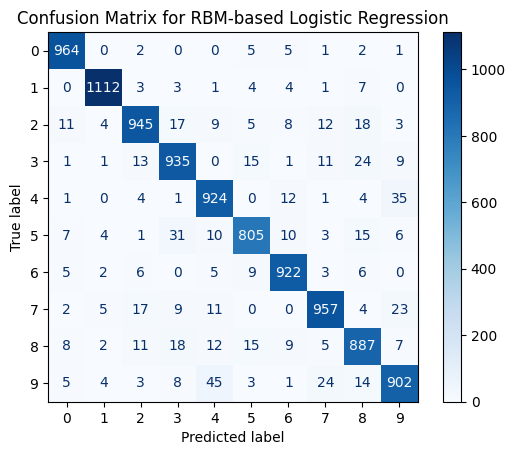

In [182]:
# Print classification report
print("Classification Report:")
print(classification_report(np.array(y_test_rbm).squeeze(1), y_pred_rbm))

# Compute confusion matrix
cm = confusion_matrix(np.array(y_test_rbm).squeeze(1), y_pred_rbm)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for RBM-based Logistic Regression")
plt.show()

# Secure RBM

In [173]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [66]:
transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Lambda(lambda x: (x > 0.5).float())  # Binarize the data
        #transforms.Normalize((0.5,), (0.5,))
    ])

# Load the MNIST dataset
def load_mnist(batch_size=64):
        train_dataset = datasets.MNIST(
            root="./data",
            train=True,
            transform=transform,
            download=True
        )

        test_dataset = datasets.MNIST(
            root="./data",
            train=False,
            transform=transform,
            download=True
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False
        )

        return train_loader, test_loader

train_loader, test_loader = load_mnist()

In [ ]:
import torch
import random
from sympy import mod_inverse

# ElGamal key generation for tensors
def generate_keys(p, shape):
    """Generate ElGamal public and private keys for tensors."""
    g = torch.randint(2, p - 2, shape)  # Generator tensor
    x = torch.randint(1, p - 2, shape)  # Private key tensor
    y = torch.pow(g, x) % p  # Public key tensor
    return (p, g, y), x  # Public key: (p, g, y), Private key: x

# ElGamal encryption for tensors
def encrypt(public_key, message):
    p, g, y = public_key
    k = torch.randint(1, p - 2, message.shape)  # Random integer tensor k
    c1 = torch.pow(g, k) % p
    c2 = (message * torch.pow(y, k)) % p
    return c1, c2

# ElGamal decryption (partial and final) for tensors
def decrypt_partial(private_key, public_key, ciphertext):
    p, g, y = public_key
    c1, c2 = ciphertext
    s = torch.pow(c1, private_key) % p  # Shared secret tensor
    return c2, s  # Partially decrypted message with the shared secret

def decrypt_final(partially_decrypted, shared_secret, p):
    c2, s = partially_decrypted

    # Handle the case where s = 0 (modular inverse of 0 does not exist)
    s = torch.where(s == 0, torch.tensor(1, dtype=s.dtype), s)

    # Compute the modular inverse of s
    s_inv = torch.tensor([mod_inverse(int(val), p) for val in s.flatten()]).reshape(s.shape)

    # Decrypt the message
    message = (c2 * s_inv) % p
    return message

# Sigmoid function for tensors
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))  # Sigmoid function for tensors

# Function to generate possible_input as a grid of tensors
def generate_possible_input(y):
    """Generate the nearest tensor to y, where each element is rounded to the nearest 0.1."""
    # Round each element of y to the nearest 0.1
    possible_input = torch.round(y * 10) / 10
    return [possible_input]

# Secure Sigmoid Computation for tensors
def secure_sigmoid(x, y):
    """Securely compute sigmoid(x + y) using ElGamal encryption for tensors."""
    p = 467  # A prime number
    shape = x.shape  # Shape of the input tensors

    possible_input = generate_possible_input(y)

    # Step 1: Party A generates a random number R and computes mi = sigmoid(x + i) - R for i in possible_input
    #print(torch.max(y))
    R = torch.randint(1, int(torch.max(y)) + 2, shape)  # Random tensor R

    # Generate keys
    public_key, private_key = generate_keys(p, shape)

    encrypted_messages = []

    # Iterate over each tensor i in the set possible_input
    for i in possible_input:
        m_i = (sigmoid(x + i) * p - R).int()  # Scale sigmoid to match finite field
        encrypted_messages.append(encrypt(public_key, m_i))

    # Step 2: Party B selects the encrypted message corresponding to its input y
    selected_ciphertexts = encrypted_messages[0]  # Reshape to match tensor shape

    # Party B re-randomizes the selected ciphertexts
    random_s = torch.randint(1, p - 1, shape)
    randomized_c1 = (selected_ciphertexts[0] * torch.pow(public_key[1], random_s)) % p
    randomized_c2 = (selected_ciphertexts[1] * torch.pow(public_key[2], random_s)) % p
    randomized_encrypted = (randomized_c1, randomized_c2)

    # Step 3: Party A partially decrypts and sends it back
    partially_decrypted_c2, shared_secret_a = decrypt_partial(private_key, public_key, randomized_encrypted)

    # Step 4: Party B completes decryption
    final_message_b = decrypt_final((partially_decrypted_c2, shared_secret_a), random_s, p)

    # Party B computes final sigmoid value
    result = (final_message_b + R) / p  # Reverse scaling

    return torch.where(result > 1, torch.tensor(0.1), R/p), torch.where(result > 1, result - 1.1, final_message_b / p)

# Secure Multiplication Computation for tensors
def secure_multiplication(x, y):
    """Securely compute x * y using ElGamal encryption for tensors."""
    p = 467  # A prime number
    shape = torch.matmul(x,y).shape  # Shape of the input tensors

    possible_input = generate_possible_input(y)

    # Step 1: Party A generates a random number R and computes mi = (x * i) - R for i in possible_input
    R = torch.randint(1, int(torch.max(y)) + 2, shape)  # Random tensor R

    # Generate keys
    public_key, private_key = generate_keys(p, shape)

    encrypted_messages = []

    # Iterate over each tensor i in the set possible_input
    for i in possible_input:
        m_i = (torch.matmul(x,i) * 10 - R).int()
        #print(m_i.shape) # Scale multiplication to match finite field
        encrypted_messages.append(encrypt(public_key, m_i))

    # Step 2: Party B selects the encrypted message corresponding to its input y
    selected_ciphertexts = encrypted_messages[0]

    # Party B re-randomizes the selected ciphertexts
    random_s = torch.randint(1, p - 1, shape)
    randomized_c1 = (selected_ciphertexts[0] * torch.pow(public_key[1], random_s)) % p
    randomized_c2 = (selected_ciphertexts[1] * torch.pow(public_key[2], random_s)) % p
    randomized_encrypted = (randomized_c1, randomized_c2)

    # Step 3: Party A partially decrypts and sends it back
    partially_decrypted_c2, shared_secret_a = decrypt_partial(private_key, public_key, randomized_encrypted)

    # Step 4: Party B completes decryption
    final_message_b = decrypt_final((partially_decrypted_c2, shared_secret_a), random_s, p)

    # Party B computes final multiplication value
    result = (final_message_b + R) / 10  # Reverse scaling

    return torch.where(result > 1, torch.tensor(0.1), R/10), torch.where(result > 1, result - 1.1, final_message_b / 10)


In [158]:
class SecureRBM:
    def __init__(self, input=None, n_visible=784, n_hidden=128, W1=None, W2=None, hbias=None, vbias1=None, vbias2=None, numpy_rng=None):
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        if numpy_rng is None:
            numpy_rng = np.random.RandomState(1234)

        if W1 is None:
            a = 1. / n_visible
            W1 = numpy_rng.uniform(-a, a, size=(n_visible//2, n_hidden))

        if W2 is None:
            a = 1. / n_visible
            W2 = numpy_rng.uniform(-a, a, size=(n_visible//2, n_hidden))

        if hbias is None:
            hbias = np.zeros(n_hidden)

        if vbias1 is None:
            vbias = np.zeros(n_visible)


        self.W1 = W1
        self.W2 = W2
        self.hbias = hbias
        self.vbias = vbias
        self.numpy_rng = numpy_rng

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample_h_given_vA(self, v):
        h_mean = np.dot(v, self.W1) + self.hbias
        #h_sample = self.numpy_rng.binomial(size=h_mean.shape, n=1, p=h_mean)
        return h_mean

    def sample_h_given_vB(self, v):
        h_mean = np.dot(v, self.W2) + self.hbias
        #h_sample = self.numpy_rng.binomial(size=h_mean.shape, n=1, p=h_mean)
        return h_mean

    def sample_v_given_hA(self, h):
        W = np.concatenate((self.W1 , self.W2))
        v_mean = np.dot(h, W.T) + self.vbias
        #v_sample = self.numpy_rng.binomial(size=v_mean.shape, n=1, p=v_mean)
        return v_mean

    def sample_v_given_hB(self, h):
        W = np.concatenate((self.W1 , self.W2))
        v_mean = np.dot(h, W.T) + self.vbias
        #v_sample = self.numpy_rng.binomial(size=v_mean.shape, n=1, p=v_mean)
        return v_mean


    def gibbs_hvh_secure(self, h0_1 , h0_2):
        v1_mean1 = self.sample_v_given_hA(h0_1)
        v1_mean2 = self.sample_v_given_hB(h0_1)

        v_1 = self.secure_sig(v1_mean1 , v1_mean2)

        h1_mean1= self.sample_h_given_vA(v_1[: , :self.n_visible//2] )
        h1_mean2= self.sample_h_given_vB(v_1[: , self.n_visible//2:] )

        h_1 = secure_sig(h1_mean1 , h1_mean2)

        return v_1, v_1, h_1, h_1


    def secure_sig(self, h1 ,h2):
        return self.sigmoid(h1+h2)

    def contrastive_divergence(self, data, k=1, lr=0.1):
        data_A = data[: , :self.n_visible//2]
        data_B = data[: , self.n_visible//2:]
        ph_mean1 = self.sample_h_given_vA(data_A)
        ph_mean2 = self.sample_h_given_vB(data_B)
        h0 = secure_sigmoid(ph_mean1, ph_mean2)

        nv_mean, nv_sample, nh_mean, nh_sample = self.gibbs_hvh_secure(h0/2 , h0/2)



        chain_start = h0
        for step in range(k):
            if step == 0:
                nv_mean, nv_sample, nh_mean, nh_sample = self.gibbs_hvh_secure(chain_start/2 , chain_start/2)
            else:
                nv_mean, nv_sample, nh_mean, nh_sample = self.gibbs_hvh_secure(nh_sample/2 , nh_sample/2)


        self.W1 += lr * (np.dot(data_A.T, h0) - np.dot(nv_sample[: , :self.n_visible//2].T, nh_mean)) / len(data_A)
        self.W2 += lr * (np.dot(data_B.T, h0) - np.dot(nv_sample[: , self.n_visible//2:].T, nh_mean)) / len(data_B)


        self.vbias += lr * np.mean(data - nv_sample, axis=0)
        self.hbias += lr * np.mean(h0 - nh_mean, axis=0)

    def reconstruct(self, v):
        h = self.sigmoid(np.dot(v, self.W) + self.hbias)
        reconstructed_v = self.sigmoid(np.dot(h, self.W.T) + self.vbias)
        return reconstructed_v

    def save_model(self, file_path):
        with open(file_path, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load_model(file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)

In [156]:
def train_rbm(train_loader, test_loader, n_visible, n_hidden, learning_rate, epochs, k):
      secure_rbm = SecureRBM(n_visible=n_visible, n_hidden=n_hidden)

      for epoch in range(epochs):
            for batch, _ in train_loader:
                batch = batch.view(-1, n_visible).numpy()
                secure_rbm.contrastive_divergence(batch, k=k, lr=learning_rate)

            # test_data = next(iter(test_loader))[0].view(-1, n_visible).numpy()
            # reconstruction = rbm.reconstruct(test_data)
            # loss = np.mean((test_data - reconstruction) ** 2)
            print(f"Epoch {epoch + 1}, k={k}")

      return secure_rbm

In [159]:
# Parameters
num_visible = 28 * 28  # Number of visible units
num_hidden = 256   # Number of hidden units
learning_rate = 0.1
epochs = 5


print("Training RBM with k=1")
secure_rbm = train_rbm(train_loader, test_loader, num_visible, num_hidden, learning_rate, epochs, k=1)
secure_rbm.save_model("secure_rbm.pkl")

Training RBM with k=1
Epoch 1, k=1
Epoch 2, k=1
Epoch 3, k=1
Epoch 4, k=1
Epoch 5, k=1


In [161]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Extract features using RBM
def extract_features_rbm(rbm, loader):
    features = []
    labels = []

    with torch.no_grad():
        for batch, lbls in loader:
            batch = batch.view(-1, rbm.n_visible)
            prob_h = rbm.sample_h_given_vA(batch[: , :rbm.n_visible//2] )
            features.append(prob_h)
            labels.append(lbls)

    return features, labels

transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
x_train_rbm, y_train_rbm = extract_features_rbm(secure_rbm, train_loader)
x_test_rbm, y_test_rbm = extract_features_rbm(secure_rbm, test_loader)

# Train a logistic regression model on RBM features
clf_rbm = LogisticRegression(max_iter=3000)
clf_rbm.fit(np.array(x_train_rbm).squeeze(1), np.array(y_train_rbm).squeeze(1))

# Evaluate the model
y_pred_rbm = clf_rbm.predict(np.array(x_test_rbm).squeeze(1))
accuracy_rbm = accuracy_score(np.array(y_test_rbm).squeeze(1), y_pred_rbm)
print(f"RBM Feature Classification Accuracy: {accuracy_rbm:.4f}")


RBM Feature Classification Accuracy: 0.8502


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       980
           1       0.92      0.97      0.94      1135
           2       0.85      0.78      0.81      1032
           3       0.77      0.76      0.77      1010
           4       0.86      0.86      0.86       982
           5       0.83      0.84      0.83       892
           6       0.91      0.92      0.92       958
           7       0.84      0.84      0.84      1028
           8       0.79      0.74      0.76       974
           9       0.80      0.85      0.82      1009

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



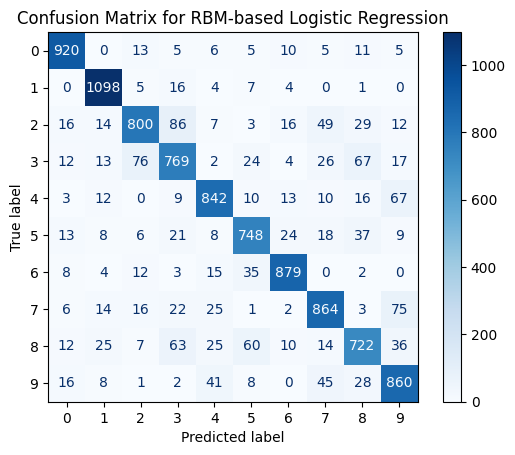

In [174]:
# Print classification report
print("Classification Report:")
print(classification_report(np.array(y_test_rbm).squeeze(1), y_pred_rbm))

# Compute confusion matrix
cm = confusion_matrix(np.array(y_test_rbm).squeeze(1), y_pred_rbm)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for RBM-based Logistic Regression")
plt.show()